In [2]:
import pandas as pd
from pathlib import Path
import re

In [3]:
IR_PLAG = Path('..', 'IR-Plag-Dataset')
IR_PLAG_DS = []

for entry in IR_PLAG.iterdir():
  original = list((entry / 'original').iterdir())[0]

  plagiarized = list(
    filter(
      lambda x: x.is_file(), 
      (entry / 'plagiarized').rglob('*')
    )
  )

  non_plagiarized = list(
    filter(
      lambda x: x.is_file(), 
      (entry / 'non-plagiarized').rglob('*')
    )
  )

  IR_PLAG_DS.append([ original, plagiarized, non_plagiarized ])

In [4]:
line_comments = re.compile(r'//.*$', flags=re.MULTILINE)
block_comments = re.compile(r'/\*.*?\*/', flags=re.DOTALL)
tabs = re.compile(r'\t', flags=re.DOTALL)
newlines = re.compile(r'\n+', flags=re.DOTALL)

def process_java_file(path: Path):
  with open(path, 'r', encoding='utf-8') as f:
    filebuff = f.read()

  filebuff = line_comments.sub('', filebuff)
  filebuff = block_comments.sub('', filebuff)
  filebuff = tabs.sub('', filebuff)
  filebuff = newlines.sub(' ', filebuff)

  return filebuff


In [5]:
ir_plag_rows = {
  'original': [],
  'untrusted': [],
  'plagiarism': [],
}

for original, plagiarized, non_plagiarized  in IR_PLAG_DS:
  original = process_java_file(original)

  for plagFile in plagiarized:
    ir_plag_rows['original'].append(original)
    ir_plag_rows['untrusted'].append(process_java_file(plagFile))
    ir_plag_rows['plagiarism'].append(1) # True

  for nonPlag in non_plagiarized:
    ir_plag_rows['original'].append(original)
    ir_plag_rows['untrusted'].append(process_java_file(nonPlag))
    ir_plag_rows['plagiarism'].append(0) # False

ir_plag_dataset = pd.DataFrame(ir_plag_rows)

ir_plag_dataset.head()

,original,untrusted,plagiarism
0,public class T1 { public static void main(Str...,public class L1 { public static void main...,1
1,public class T1 { public static void main(Str...,public class Main { public static void mai...,1
2,public class T1 { public static void main(Str...,public class Main { public static void ma...,1
3,public class T1 { public static void main(Str...,public class T1 { public static void main(Str...,1
4,public class T1 { public static void main(Str...,class HelloWorld { public static void main(Str...,1


In [6]:
with open(IR_PLAG_DS[0][0]) as f:
  print(f'|Before Cleaning|\n{f.read()}\n|After Cleaning|\n{ir_plag_dataset["original"][0]}')

|Before Cleaning|

public class T1 {
	public static void main(String[] args) {
		System.out.println("Welcome to Java");
		System.out.println("Welcome to Java");
		System.out.println("Welcome to Java");
		System.out.println("Welcome to Java");
		System.out.println("Welcome to Java");
	}

}

|After Cleaning|
 public class T1 { public static void main(String[] args) { System.out.println("Welcome to Java"); System.out.println("Welcome to Java"); System.out.println("Welcome to Java"); System.out.println("Welcome to Java"); System.out.println("Welcome to Java"); } } 


In [7]:
CONPLAG_PATH = Path('..', 'conplag_v2')
CONPLAG_DS = CONPLAG_PATH / 'version_2'
conplag_labels = pd.read_csv(CONPLAG_PATH / 'labels.csv')
conplag_labels.head()

,sub1,sub2,problem,verdict
0,0fd5b95a,6490bbe8,19,0
1,464a03b8,ff1fc018,20,0
2,3e6def38,548ffb07,14,1
3,0b91922c,71a4f6d2,6,0
4,9291ca83,d6fb3b9e,15,0


In [8]:
conplag_labels['pair'] = conplag_labels.apply(lambda row: f'{row["sub1"]}_{row["sub2"]}', axis=1)
conplag_labels.set_index('pair', inplace=True)
conplag_labels.head()

,sub1,sub2,problem,verdict
pair,,,,
0fd5b95a_6490bbe8,0fd5b95a,6490bbe8,19,0
464a03b8_ff1fc018,464a03b8,ff1fc018,20,0
3e6def38_548ffb07,3e6def38,548ffb07,14,1
0b91922c_71a4f6d2,0b91922c,71a4f6d2,6,0
9291ca83_d6fb3b9e,9291ca83,d6fb3b9e,15,0


In [9]:
conplag_rows = {
  'original': [],
  'untrusted': [],
  'plagiarism': [],
}

for directory in (CONPLAG_DS).iterdir():
  [sub1, sub2] = list(directory.iterdir())
  conplag_rows['original'].append(process_java_file(sub1))
  conplag_rows['untrusted'].append(process_java_file(sub2))
  conplag_rows['plagiarism'].append(conplag_labels.loc[directory.name, 'verdict'])

conplag_dataset = pd.DataFrame(conplag_rows)

conplag_dataset.head()

,original,untrusted,plagiarism
0,import java.io.BufferedReader; import java.io....,import java.io.BufferedReader; import java.io....,1
1,import java.io.BufferedReader; import java.io....,import java.io.BufferedReader; import java.io....,0
2,import java.io.*; import java.util.*; public c...,import java.util.*; import java.io.*; public c...,0
3,import java.util.*; import java.io.*; public c...,import java.io.*; import java.util.*; import j...,0
4,import java.util.*; import java.io.*; public c...,import java.io.*; import java.util.*; public c...,0


In [10]:
merged_ds = pd.merge(conplag_dataset, ir_plag_dataset, how='outer')
print(len(merged_ds), len(conplag_dataset), len(ir_plag_dataset))
merged_ds.head()

1371 911 460


,original,untrusted,plagiarism
0,public class T1 { public static void main(Str...,import java.util.Scanner; public class Soal1 ...,0
1,public class T1 { public static void main(Str...,public class Kasus1L1 { public stati...,1
2,public class T1 { public static void main(Str...,public class Kasus1L3 { public stati...,1
3,public class T1 { public static void main(Str...,public class Kasus1L6 { public ...,1
4,public class T1 { public static void main(Str...,public class L1 { public static void main...,1


In [11]:
merged_ds.to_csv(Path('..', 'plag_dataset.csv'))

Text(0, 0.5, 'Cantidad de Casos')

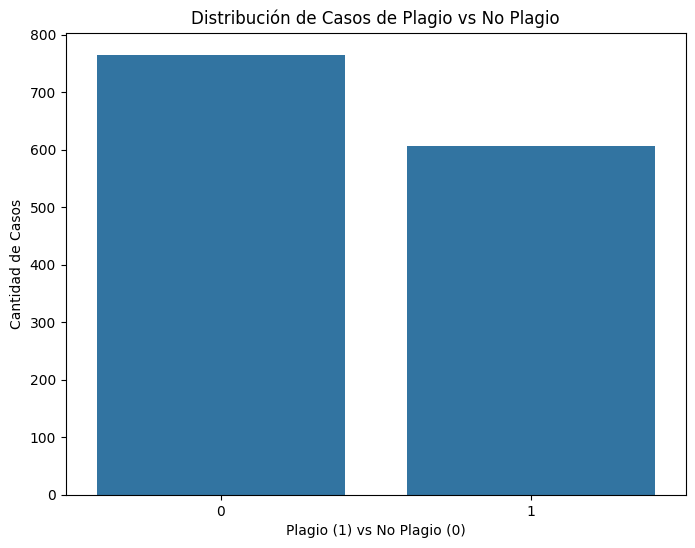

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.countplot(data=merged_ds, x='plagiarism')
plt.title('Distribución de Casos de Plagio vs No Plagio')
plt.xlabel('Plagio (1) vs No Plagio (0)')
plt.ylabel('Cantidad de Casos')

Text(0, 0.5, 'Longitud del Código Sospechoso')

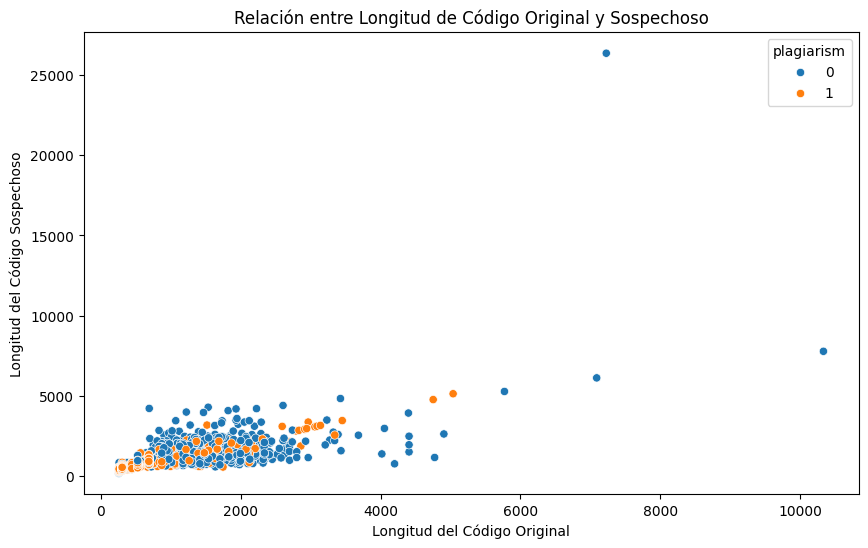

In [13]:
merged_ds['original_length'] = merged_ds['original'].str.len()
merged_ds['untrusted_length'] = merged_ds['untrusted'].str.len()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_ds, x='original_length', y='untrusted_length', hue='plagiarism')
plt.title('Relación entre Longitud de Código Original y Sospechoso')
plt.xlabel('Longitud del Código Original')
plt.ylabel('Longitud del Código Sospechoso')

Text(0.5, 1.0, 'Distribución de Longitud del Código Sospechoso')

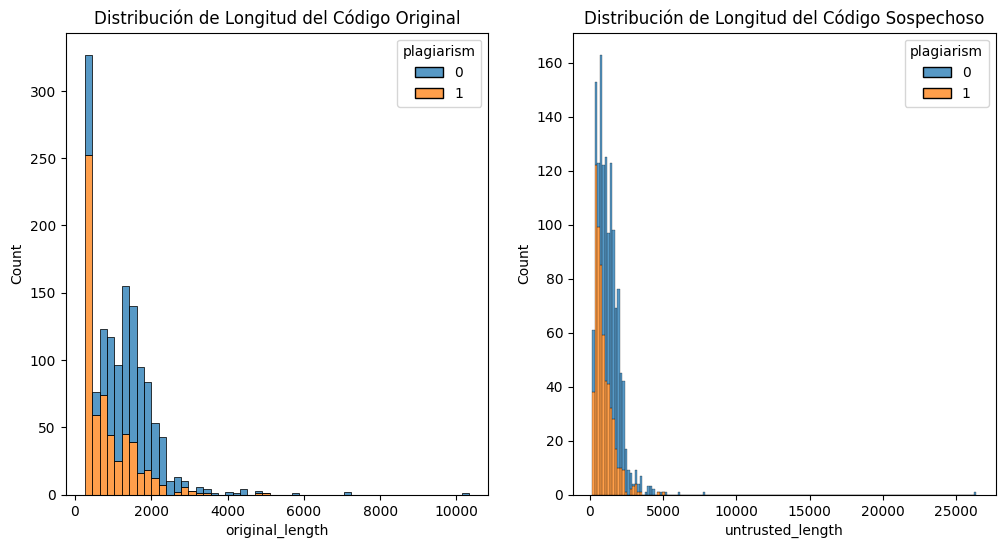

In [14]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(data=merged_ds, x='original_length', hue='plagiarism', multiple="stack")
plt.title('Distribución de Longitud del Código Original')

plt.subplot(1, 2, 2)
sns.histplot(data=merged_ds, x='untrusted_length', hue='plagiarism', multiple="stack")
plt.title('Distribución de Longitud del Código Sospechoso')

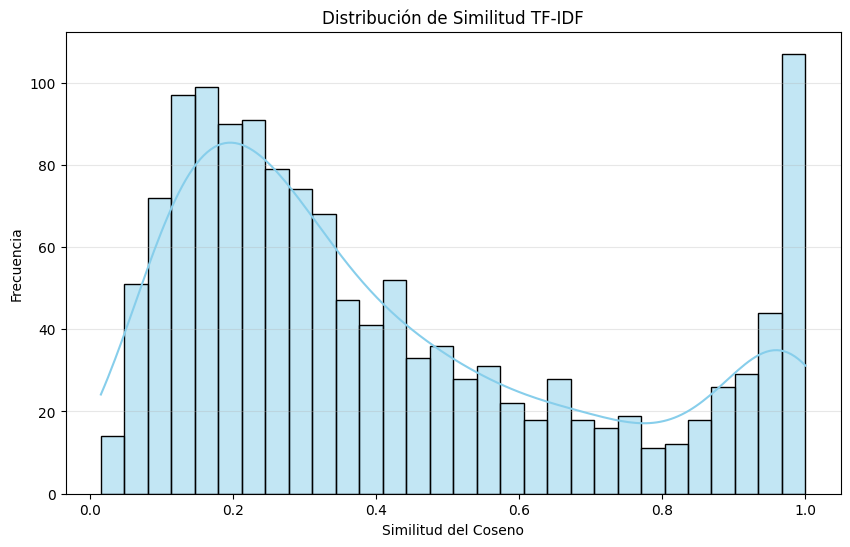

In [22]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

vectorizer = TfidfVectorizer()

all_texts = pd.concat([merged_ds['original'], merged_ds['untrusted']])
vectorizer.fit(all_texts)

similarities = []
for i, row in merged_ds.iterrows():
    original_vec = vectorizer.transform([row['original']])
    untrusted_vec = vectorizer.transform([row['untrusted']])
    similarity = cosine_similarity(original_vec, untrusted_vec)[0][0]
    similarities.append(similarity)

merged_ds['tfidf_similarity'] = similarities

plt.figure(figsize=(10, 6))
sns.histplot(merged_ds['tfidf_similarity'], bins=30, kde=True, color='skyblue')
plt.title('Distribución de Similitud TF-IDF')
plt.xlabel('Similitud del Coseno')
plt.ylabel('Frecuencia')
plt.grid(axis='y', alpha=0.3)
plt.show()